# Task 4
This serves as a template which will guide you through the implementation of this task. It is advised to first read the whole template and get a sense of the overall structure of the code before trying to fill in any of the TODO gaps.
This is the jupyter notebook version of the template. For the python file version, please refer to the file `template_solution.py`.

First, we import necessary libraries:

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam, AdamW
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer

Depending on your approach, you might need to adapt the structure of this template or parts not marked by TODOs.
It is not necessary to completely follow this template. Feel free to add more code and delete any parts that are not required.

In [1]:
#from google.colab import drive
##drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/IML/Task 4

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/IML/Task 4


In [7]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_val = pd.read_csv("train.csv")
test_val = pd.read_csv("test_no_score.csv")

In [5]:
# TODO: Fill out ReviewDataset
class ReviewDataset(Dataset):
    def __init__(self, data_frame):
        self.dataset = data_frame
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        self.max_length = 512

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        combined_column = list(self.dataset["title"] + ' ' + self.dataset["sentence"])
        data_item = combined_column[index]
        if "score" in self.dataset.columns:
            labels = self.dataset["score"][index]
        else:
            labels = torch.zeros(len(self.dataset))[index]

        encoding = self.tokenizer.encode_plus(
          data_item,
          add_special_tokens=True,
          max_length=self.max_length,
          return_token_type_ids=False,
          padding='max_length',
          return_attention_mask=True,
          return_tensors='pt',
          truncation=True
        )

        return {
          'review_text': data_item,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'labels': torch.tensor(labels, dtype=torch.float)
        }

In [8]:
train_dataset = ReviewDataset(train_val)
test_dataset = ReviewDataset(test_val)

BATCH_SIZE = 64 # TODO: Set the batch size according to both training performance and available memory
torch.manual_seed(42)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False, num_workers=2, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [9]:
class MyModule(nn.Module):
    def __init__(self):
        super(MyModule, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        hidden_size = self.distilbert.config.hidden_size
        self.pre_classifier = nn.Linear(hidden_size, hidden_size)  # DistilBERT's hidden size is 768
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        distilbert_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = distilbert_output.last_hidden_state[:, 0, :]
        pooled_output = self.pre_classifier(pooled_output)
        pooled_output = self.relu(pooled_output)
        pooled_output = self.dropout(pooled_output) # regularization
        logits = self.classifier(pooled_output)

        return logits

In [15]:
# TODO: Set up loss function, optimiser, and scheduler

model = MyModule().to(DEVICE)
for param in model.distilbert.parameters():
    param.requires_grad = False

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = None
NUM_EPOCHS = 10  # TODO: Set the number of epochs

train_loss_to_plot = []
val_loss_to_plot = []

# TODO: Set up training loop
for epoch in range(NUM_EPOCHS):

    training_loss = 0
    evaluation_loss = 0

    model.train()
    for batch in train_loader:
        batch_length = len(batch['input_ids'])
        validation_split = int(np.floor(0.8 * batch_length))

        input_ids = batch['input_ids'].to(DEVICE)[:validation_split]
        attention_mask = batch['attention_mask'].to(DEVICE)[:validation_split]
        labels = batch['labels'].to(DEVICE)[:validation_split]

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = torch.clamp(logits, min=0, max=10)
        loss = criterion(logits.squeeze(), labels)
        training_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Validation loop
        with torch.no_grad():
            input_ids = batch['input_ids'].to(DEVICE)[validation_split:]
            attention_mask = batch['attention_mask'].to(DEVICE)[validation_split:]
            labels = batch['labels'].to(DEVICE)[validation_split:]
            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = torch.clamp(logits, min=0, max=10)
            val_loss = criterion(logits.squeeze(), labels)
            evaluation_loss += val_loss.item()

    avg_train_loss = training_loss / len(train_loader)
    avg_val_loss = evaluation_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, training loss: {avg_train_loss:.4f}; validation loss: {avg_val_loss:.4f}")

    train_loss_to_plot.append(avg_train_loss)
    val_loss_to_plot.append(avg_val_loss)

# 3 epochs took 12 mins

Epoch 1, training loss: 6.0637; validation loss: 6.1119
Epoch 2, training loss: 4.0445; validation loss: 4.1552
Epoch 3, training loss: 3.9090; validation loss: 3.9842
Epoch 4, training loss: 3.8162; validation loss: 4.0166
Epoch 5, training loss: 3.7516; validation loss: 3.8794
Epoch 6, training loss: 3.6886; validation loss: 3.6828
Epoch 7, training loss: 3.6104; validation loss: 3.5952
Epoch 8, training loss: 3.5699; validation loss: 3.4354
Epoch 9, training loss: 3.6660; validation loss: 3.7676
Epoch 10, training loss: 3.5609; validation loss: 3.4869


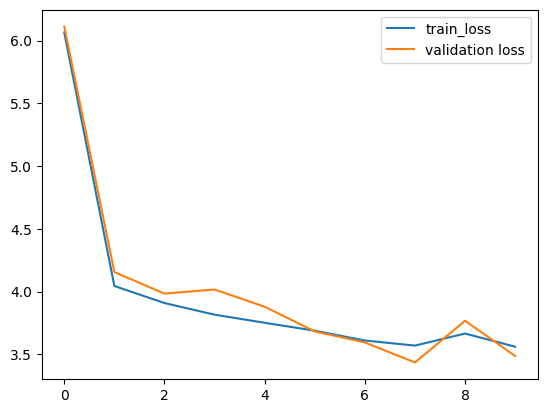

In [16]:
import matplotlib.pyplot as plt

x_axis = [i for i in range(NUM_EPOCHS)] #list(range(NUM_EPOCHS))
plt.plot(x_axis, train_loss_to_plot, label="train_loss")
plt.plot(x_axis, val_loss_to_plot, label="validation loss")
plt.legend()
plt.show()

In [17]:
# Train the model on the whole data set

model = MyModule().to(DEVICE)
for param in model.distilbert.parameters():
    param.requires_grad = False

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = None
NUM_EPOCHS = 10  # TODO: Set the number of epochs

train_loss_to_plot = []

# TODO: Set up training loop
for epoch in range(NUM_EPOCHS):

    training_loss = 0

    model.train()
    for batch in train_loader:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = torch.clamp(logits, min=0, max=10)
        loss = criterion(logits.squeeze(), labels)
        training_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = training_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, training loss: {avg_train_loss:.4f}")

    train_loss_to_plot.append(avg_train_loss)

Epoch 1, training loss: 6.1064
Epoch 2, training loss: 4.1280
Epoch 3, training loss: 3.8679
Epoch 4, training loss: 3.7901
Epoch 5, training loss: 3.6922
Epoch 6, training loss: 3.5836
Epoch 7, training loss: 3.6604
Epoch 8, training loss: 3.5942
Epoch 9, training loss: 3.5656
Epoch 10, training loss: 3.4967


In [18]:
# TODO: Set up evaluation loop

model.eval()

results = []
for batch in tqdm(test_loader, total=len(test_loader)):
    input_ids = batch['input_ids'].to(DEVICE)
    attention_mask = batch['attention_mask'].to(DEVICE)
    labels = batch['labels'].to(DEVICE)

    with torch.no_grad():
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.clamp(logits, min=0, max=10).cpu().numpy()
        results.extend(predictions)

with open("result.txt", "w") as f:
    for val in np.concatenate(results):
        f.write(f"{val}\n")

  0%|          | 0/16 [00:00<?, ?it/s]<ipython-input-5-eac501d6a692>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(labels, dtype=torch.float)
<ipython-input-5-eac501d6a692>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'labels': torch.tensor(labels, dtype=torch.float)
100%|██████████| 16/16 [00:17<00:00,  1.07s/it]
